<a href="https://colab.research.google.com/github/Alepescinaa/ScientificTools/blob/main/Project1/Cp3/checkpoint3_submission1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project1/Cp3

Cloning into 'ScientificTools'...
remote: Enumerating objects: 1631, done.
remote: Counting objects: 100% (611/611), done.
remote: Compressing objects: 100% (385/385), done.
remote: Total 1631 (delta 326), reused 408 (delta 200), pack-reused 1020
Receiving objects: 100% (1631/1631), 366.61 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (650/650), done.
Updating files: 100% (597/597), done.
/content/ScientificTools/Project1/Cp3


In [3]:
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow import keras

!pip -q install pyDOE
from pyDOE import lhs

# set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

  Preparing metadata (setup.py) ... done


In [4]:
from tqdm import tqdm

In [51]:
basis = np.loadtxt('U.txt')

In [52]:
c1_min = -14901.761523641348
c2_min = -1643.3531739641028
c3_min = -1666.6210868100304
c4_min = -776.3216433826997
c5_min = -1093.9739152896575
c6_min = -717.0421965070655
c7_min = -469.99557868963177
c8_min = -328.78040407702787
c9_min = -257.80546030166914
c10_min = -216.04071913734091

delta_c1 = 2757.9742726495806
delta_c2 = 3222.8072248540147
delta_c3 = 3374.1788513410456
delta_c4 = 2057.0735047085477
delta_c5 = 2141.6130258360363
delta_c6 = 1254.632759668237
delta_c7 = 908.8248889044971
delta_c8 = 857.0009344594488
delta_c9 = 575.4097642690142
delta_c10 = 573.6208325456312

In [53]:
# collocation points
Ncl = 151**2
Xcl = lhs(2,Ncl)
xcl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,0],dtype=tf.float64),axis=-1)
ycl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,1],dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)

In [54]:
def penalty(param, lower_bound, upper_bound):
    return tf.reduce_sum(tf.square(tf.maximum(param - upper_bound, 0)) +
                         tf.square(tf.maximum(lower_bound - param, 0)))

# PINN loss function
def loss(xcl,ycl,xmeas,ymeas,umeas,coeff_1,coeff_2,coeff_3,coeff_other):
    input_data=tf.concat([xmeas,ymeas],1)
    umeas_pred = PINN(input_data)
    r_pred   = r_PINN(xcl,ycl,coeff_1,coeff_2,coeff_3,coeff_other)

    # loss components
    mse_meas  = tf.reduce_mean(tf.pow(umeas-umeas_pred,2))
    mse_r  = tf.reduce_mean(tf.abs(r_pred))

    # bc
    y0 = tf.constant([-0.517409965],dtype=tf.float64)
    mse_bc= tf.pow( PINN( tf.transpose( tf.stack( [tf.constant([1.5],dtype=tf.float64), y0] ) ) ) ,2)

    #penalty
    mse_penalty = penalty(coeff_other[0],0,1)+penalty(coeff_other[1],0,1)+penalty(coeff_other[2],0,1)+penalty(coeff_other[3],0,1)+penalty(coeff_other[4],0,1)+penalty(coeff_other[5],0,1)+penalty(coeff_other[6],0,1)+penalty(coeff_1,0,1)+penalty(coeff_2,0,1)+penalty(coeff_3,0,1)

    return mse_meas + mse_r + mse_bc + mse_penalty

def loss2(xcl,ycl,xmeas,ymeas,umeas):
    input_data=tf.concat([xmeas,ymeas],1)
    umeas_pred = PINN(input_data)
    r_pred   = r_PINN2(xcl,ycl)

    # loss components
    mse_meas  = tf.reduce_mean(tf.pow(umeas-umeas_pred,2))
    mse_r  = tf.reduce_mean(tf.abs(r_pred))

    # bc
    y0 = tf.constant([-0.517409965],dtype=tf.float64)
    mse_bc= tf.pow( PINN( tf.transpose( tf.stack( [tf.constant([1.5],dtype=tf.float64), y0] ) ) ) ,2)

    return mse_meas + mse_r + mse_bc


@tf.function
def r_PINN(x,y,coeff_1,coeff_2,coeff_3,coeff_other):
    input_data=tf.concat([x,y],1)
    u = PINN(input_data)
    u_x = tf.gradients(u,x)[0]
    u_y = tf.gradients(u,y)[0]
    u_grad = tf.transpose(tf.concat([u_x, u_y], axis=1))

    pi = tf.constant(np.pi,dtype=tf.float64)
    theta_fiber = tf.constant([0.13757033666666668] ,dtype=tf.float64)
    a_ratio = tf.constant([5.896298503333333], dtype=tf.float64)
    theta0 = pi/2 - theta_fiber

    a = tf.stack([tf.cos(theta0), tf.sin(theta0)])
    b = tf.stack([tf.cos(theta0-pi/2), tf.sin(theta0-pi/2)])

    D_00 = 1 / a_ratio * a[0]**2 + b[0]**2
    D_01 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_10 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_11 = 1 / a_ratio * a[1]**2 + b[1]**2

    c1 = c1_min + delta_c1 * coeff_1
    c2 = c2_min + delta_c2 * coeff_2
    c3 = c3_min + delta_c3 * coeff_3
    c4 = c4_min + delta_c4 * coeff_other[0]
    c5 = c5_min + delta_c5 * coeff_other[1]
    c6 = c6_min + delta_c6 * coeff_other[2]
    c7 = c7_min + delta_c7 * coeff_other[3]
    c8 = c8_min + delta_c8 * coeff_other[4]
    c9 = c9_min + delta_c9 * coeff_other[5]
    c10 = c10_min + delta_c10 * coeff_other[6]

    coeff_true = tf.expand_dims(tf.concat([c1[0],c2[0],c3[0],c4,c5,c6,c7,c8,c9,c10], 0), 1)

    return   (((u_x * D_00 * u_x + u_x * D_01 * u_y + u_y * D_10 * u_x + u_y * D_11 * u_y)))  - (1/(basis@coeff_true))**2

@tf.function
def r_PINN2(x,y):
    input_data=tf.concat([x,y],1)
    u = PINN(input_data)
    u_x = tf.gradients(u,x)[0]
    u_y = tf.gradients(u,y)[0]
    u_grad = tf.transpose(tf.concat([u_x, u_y], axis=1))

    pi = tf.constant(np.pi,dtype=tf.float64)
    theta_fiber = tf.constant([0.13757033666666668] ,dtype=tf.float64)
    a_ratio = tf.constant([5.896298503333333], dtype=tf.float64)
    theta0 = pi/2 - theta_fiber

    a = tf.stack([tf.cos(theta0), tf.sin(theta0)])
    b = tf.stack([tf.cos(theta0-pi/2), tf.sin(theta0-pi/2)])

    D_00 = 1 / a_ratio * a[0]**2 + b[0]**2
    D_01 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_10 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_11 = 1 / a_ratio * a[1]**2 + b[1]**2

    return  (((u_x * D_00 * u_x + u_x * D_01 * u_y + u_y * D_10 * u_x + u_y * D_11 * u_y)))  - (1/100)**2


# neural network weight gradients
@tf.function
def grad(model,xcl,ycl,xmeas,ymeas,umeas,coeff_1,coeff_2,coeff_3,coeff_other):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,xmeas,ymeas,umeas,coeff_1,coeff_2,coeff_3,coeff_other)
        grads = tape.gradient(loss_value,model.trainable_variables)
        grads_c1 = tape.gradient(loss_value,coeff_1)
        grads_c2 = tape.gradient(loss_value,coeff_2)
        grads_c3 = tape.gradient(loss_value,coeff_3)
        grads_other = tape.gradient(loss_value,coeff_other)

    return loss_value,grads,grads_c1,grads_c2,grads_c3,grads_other
    # neural network weight gradients

@tf.function
def grad2(model,xcl,ycl,xmeas,ymeas,umeas):
    with tf.GradientTape(persistent=True) as tape:
        loss_value2 = loss2(xcl,ycl,xmeas,ymeas,umeas)
        grads2 = tape.gradient(loss_value2,model.trainable_variables)
    return loss_value2, grads2

In [55]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM

regularization_strength = 1e-3

PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,),
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),

    tf.keras.layers.Dense(128, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),

    tf.keras.layers.Dense(32, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),

    tf.keras.layers.Dense(1, activation=None,
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64)
])

In [56]:
def checkpoint2_solution( x, y , t ):

  x = tf.constant(x.reshape(20, 1), dtype=tf.float64)
  y = tf.constant(y.reshape(20, 1), dtype=tf.float64)
  t = tf.constant(t.reshape(20, 1), dtype=tf.float64)

  coeff_1 = tf.Variable([[0.5]], trainable=True, dtype=tf.float64)
  coeff_2 = tf.Variable([[0.7]], trainable=True, dtype=tf.float64)
  coeff_3 = tf.Variable([[0.85]], trainable=True, dtype=tf.float64)
  coeff_other = tf.Variable([[0.5],[0.5],[0.5],[0.5],[0.5],[0.5],[0.5]], trainable=True, dtype=tf.float64)

  tf_optimizer_PINN = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.99)
  tf_optimizer_PINN.build(PINN.trainable_variables)
  tf_optimizer_c1 = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.99)
  tf_optimizer_c1.build([coeff_1])
  tf_optimizer_c2 = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.99)
  tf_optimizer_c2.build([coeff_2])
  tf_optimizer_c3 = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.99)
  tf_optimizer_c3.build([coeff_3])
  tf_optimizer_other = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.99)
  tf_optimizer_other.build([coeff_other])

  for iter in tqdm(range(1500)):

    loss_value2,grads2 = grad2(PINN,xcl,ycl,x, y, t)

    tf_optimizer_PINN.apply_gradients(zip(grads2,PINN.trainable_variables))

  for iter in tqdm(range(4000)):

    loss_value,grads,grads_c1,grads_c2,grads_c3,grads_other = grad(PINN,xcl,ycl,x, y, t,coeff_1,coeff_2,coeff_3,coeff_other)

    tf_optimizer_PINN.apply_gradients(zip(grads ,PINN.trainable_variables))
    tf_optimizer_c1.apply_gradients(zip([grads_c1], [coeff_1]))
    tf_optimizer_c2.apply_gradients(zip([grads_c2], [coeff_2]))
    tf_optimizer_c3.apply_gradients(zip([grads_c3], [coeff_3]))
    tf_optimizer_other.apply_gradients(zip([grads_other], [coeff_other]))

  c1 = c1_min + delta_c1 * coeff_1
  c2 = c2_min + delta_c2 * coeff_2
  c3 = c3_min + delta_c3 * coeff_3
  c4 = c4_min + delta_c4 * coeff_other[0]
  c5 = c5_min + delta_c5 * coeff_other[1]
  c6 = c6_min + delta_c6 * coeff_other[2]
  c7 = c7_min + delta_c7 * coeff_other[3]
  c8 = c8_min + delta_c8 * coeff_other[4]
  c9 = c9_min + delta_c9 * coeff_other[5]
  c10 = c10_min + delta_c10 * coeff_other[6]

  coeff_true = tf.expand_dims(tf.concat([c1[0],c2[0],c3[0],c4,c5,c6,c7,c8,c9,c10], 0), 1)

  speed_field_est = basis @ coeff_true

  return speed_field_est

In [57]:
CP3data = np.load("CP3data.npz")
CP3data = CP3data['arr_0']

CP3estimate = np.load("CP3field.npz")
CP3estimate = CP3estimate['arr_0']

In [58]:
ind_disp = 21
x_meas = CP3data[ind_disp][0]
y_meas = CP3data[ind_disp][1]
t_meas = CP3data[ind_disp][2]

speed_field = CP3estimate[ind_disp][0]

In [59]:
speed_field_est = checkpoint2_solution(x_meas, y_meas, t_meas)

100%|██████████| 4000/4000 [02:27<00:00, 27.06it/s]


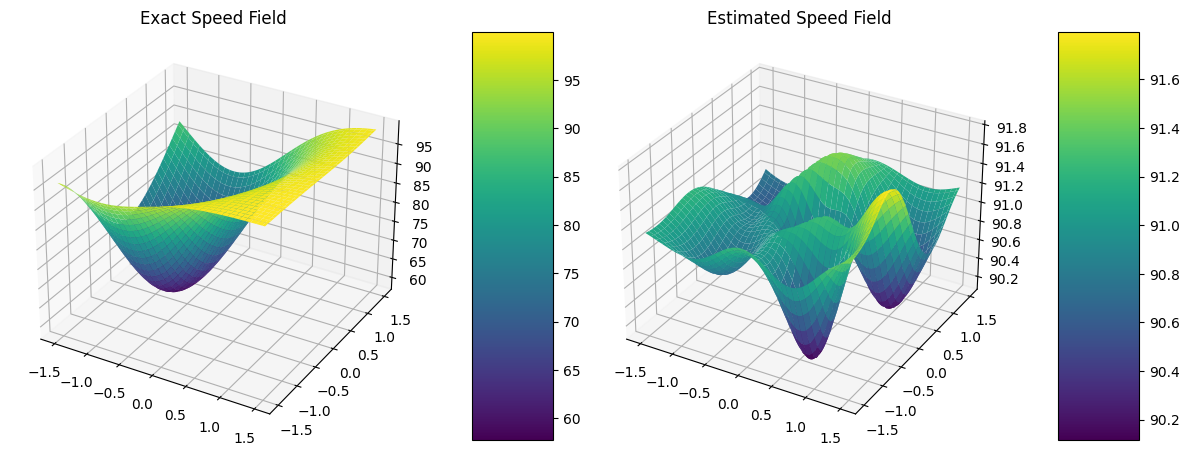

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # Assuming tf.reshape is from TensorFlow

# X, Y meshgrid
X, Y = np.meshgrid(np.linspace(-1.5, 1.5, 151), np.linspace(-1.5, 1.5, 151))

# Create figure and axes with 3D projection
fig = plt.figure(figsize=(12, 16))

# Create subplots
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot for the exact speed field
surf1 = ax1.plot_surface(X, Y, speed_field, cmap='viridis')
ax1.set_zlim(np.min(speed_field), np.max(speed_field))
ax1.set_title('Exact Speed Field')

# Create color bar for the first plot
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5, pad=0.1)
cbar1.ax.tick_params(labelsize=10)  # Adjust color bar tick size

# Plot for the estimated speed field
speed_field_est_reshaped = tf.reshape(speed_field_est, [151, 151])
surf2 = ax2.plot_surface(X, Y, speed_field_est_reshaped, cmap='viridis')
ax2.set_zlim(np.min(speed_field_est_reshaped), np.max(speed_field_est_reshaped))
ax2.set_title('Estimated Speed Field')

# Create color bar for the second plot
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5, pad=0.1)
cbar2.ax.tick_params(labelsize=10)  # Adjust color bar tick size

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

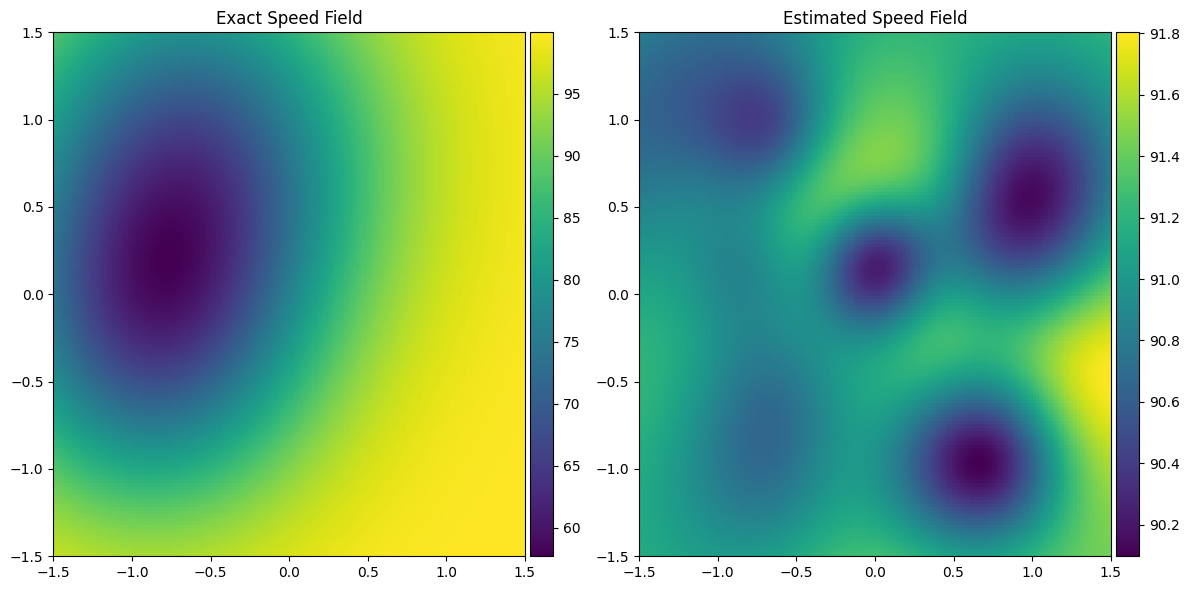

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf  # Assuming tf.reshape is from TensorFlow


X, Y = np.meshgrid(np.linspace(-1.5, 1.5, 151), np.linspace(-1.5, 1.5, 151))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for the exact speed field
im1 = ax[0].imshow(speed_field, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)],
                   origin='lower', aspect='auto', cmap='viridis')
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)
ax[0].set_title('Exact Speed Field')

# Plot for the estimated speed field
im2 = ax[1].imshow(tf.reshape(speed_field_est, [151, 151]), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)],
                   origin='lower', aspect='auto', cmap='viridis')
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)
ax[1].set_title('Estimated Speed Field')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()